Our goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD).The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

Variables:

1. Sex: male or female(Nominal)
2. Age: Age of the patient;
3. Current Smoker: whether or not the patient is a current smoker (Nominal)
4. Cigs Per Day: the number of cigarettes that the person smoked on average in one day.
5. BP Meds: whether or not the patient was on blood pressure medication (Nominal)
6. Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
7. Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
8. Diabetes: whether or not the patient had diabetes (Nominal)
9. Tot Chol: total cholesterol level (Continuous)
10. Sys BP: systolic blood pressure (Continuous)
11. Dia BP: diastolic blood pressure (Continuous)
12. BMI: Body Mass Index (Continuous)
13. Heart Rate: heart rate (Continuous )
14. Glucose: glucose level (Continuous)
15. 10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”) (Target Variable)

In [256]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('framingham.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [4]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Assumption: "education" feature is difficult to interpret so I omit it in this research.

In [5]:
df.drop(columns=['education'], inplace=True)

In [6]:
numerical = [
    'age', 'cigsPerDay', 'totChol', 'sysBP', 
    'diaBP', 'BMI', 'heartRate', 'glucose'
]

In [7]:
categorical = [
    'male', 'currentSmoker', 'BPMeds', 
    'prevalentStroke', 'prevalentHyp', 'diabetes'
]

#### Check and fill NaN

##### Numerical

In [8]:
df.isna().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

From the above it is clear that numerical columns "cigsPerDay", "totChol", "BMI", "heartRate" and "glucose" has NaN values. It order to handle this let's explore their corresponding  distributions.
I will use univariate visualization in order to understand these features.

In [9]:
df[numerical].describe()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,4238.000000,4209.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000
mean,49.584946,9.003089,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753
std,8.572160,11.920094,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998
min,32.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000
25%,42.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000
50%,49.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000
75%,56.000000,20.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000
max,70.000000,70.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000


Plot histograms with kernel density estimate to smooth the histogram, providing complementary information about the shape of the distribution. Plot box plots as well to understand outliers.

<AxesSubplot:xlabel='BMI'>

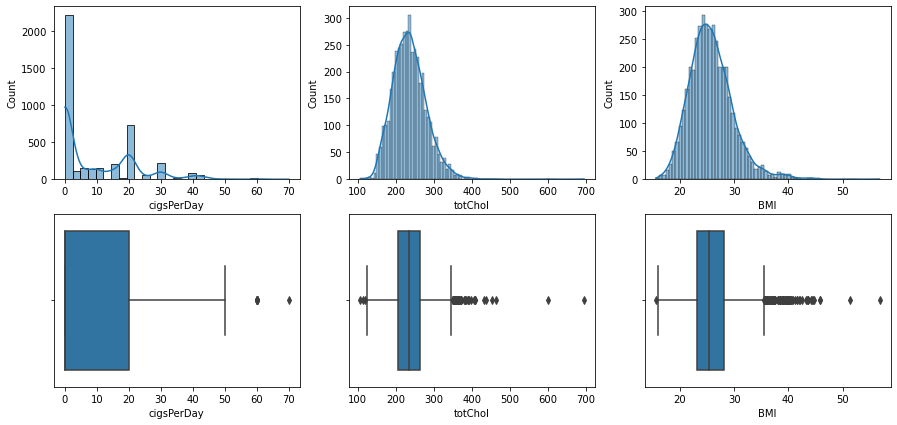

In [10]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
sns.histplot(data=df, x="cigsPerDay", kde=True, ax=axes[0, 0])
sns.histplot(data=df, x="totChol", kde=True, ax=axes[0, 1])
sns.histplot(data=df, x="BMI", kde=True, ax=axes[0, 2])
sns.boxplot(data=df, x="cigsPerDay", ax=axes[1, 0])
sns.boxplot(data=df, x="totChol", ax=axes[1, 1])
sns.boxplot(data=df, x="BMI", ax=axes[1, 2])

<AxesSubplot:xlabel='diaBP'>

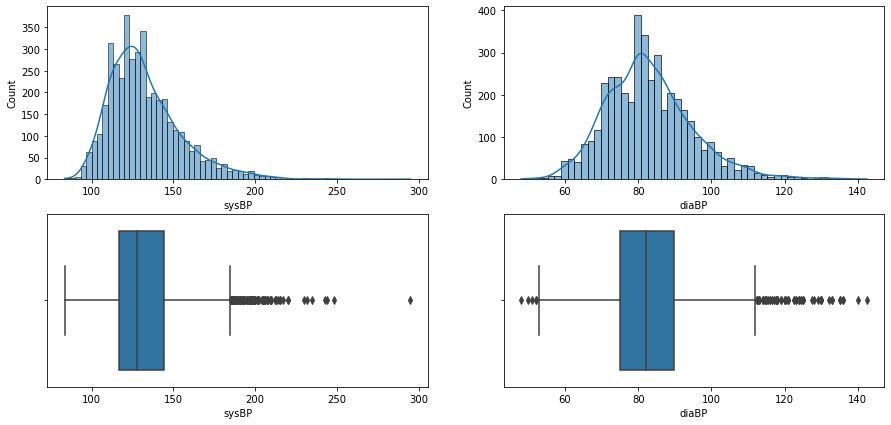

In [324]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))
sns.histplot(data=df, x="sysBP", kde=True, ax=axes[0, 0])
sns.histplot(data=df, x="diaBP", kde=True, ax=axes[0, 1])
sns.boxplot(data=df, x="sysBP", ax=axes[1, 0])
sns.boxplot(data=df, x="diaBP", ax=axes[1, 1])

<AxesSubplot:xlabel='glucose'>

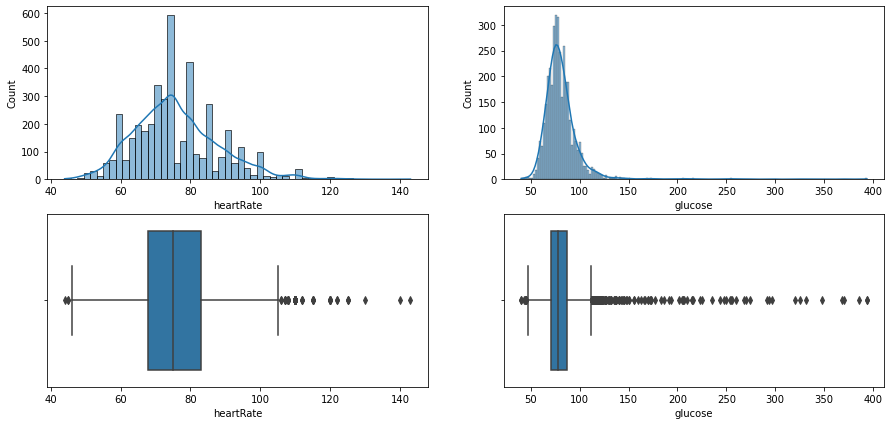

In [11]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))
sns.histplot(data=df, x="heartRate", kde=True, ax=axes[0, 0])
sns.histplot(data=df, x="glucose", kde=True, ax=axes[0, 1])
sns.boxplot(data=df, x="heartRate", ax=axes[1, 0])
sns.boxplot(data=df, x="glucose", ax=axes[1, 1])

In [441]:
perc_99_dict = {}
for feature in numerical:
    perc_99 = np.percentile(df[feature].values[~np.isnan(df[feature].values)], 99)    
    print(f'{feature} 99% percentile is {perc_99:.1f}')
    perc_99_dict[feature] = perc_99

age 99% percentile is 67.0
cigsPerDay 99% percentile is 43.0
totChol 99% percentile is 353.6
sysBP 99% percentile is 200.0
diaBP 99% percentile is 118.0
BMI 99% percentile is 39.0
heartRate 99% percentile is 110.0
glucose 99% percentile is 170.0


"cigsPerDay" feature distribution is skewed to the right.
"totChol", "BMI" and "glucose" features shows distribution skewed to the right due to outliers. Without outliers they have normal distribution.
"heartRate" feature distribution close to normal.
1. "cigsPerDay" feature NaN values could be filled with 0
2. "totChol", "BMI", "heartRate" and "glucose" features NaN values could be filled with respective median values

In [13]:
df['cigsPerDay'] = df['cigsPerDay'].fillna(0)
df['totChol'].fillna(value=df['totChol'].median(), inplace=True)
df['BMI'].fillna(value=df['BMI'].median(), inplace=True)
df['heartRate'].fillna(value=df['heartRate'].median(), inplace=True)
df['glucose'].fillna(value=df['glucose'].median(), inplace=True)

##### Categorical

<AxesSubplot:xlabel='BPMeds', ylabel='count'>

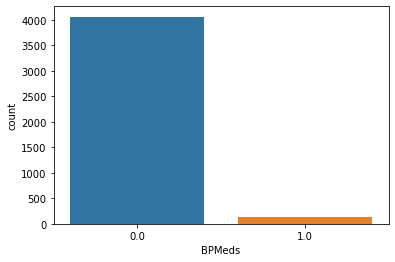

In [14]:
sns.countplot(x='BPMeds', data=df)

From plot above it can be concluded that "BPMeds" feature NaN values could be replaced with 0.0 values.

In [15]:
df['BPMeds'].fillna(0.0, inplace=True)

In [16]:
df.isna().sum()

male               0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

### EDA

In [17]:
df.TenYearCHD.value_counts()

0    3594
1     644
Name: TenYearCHD, dtype: int64

In [18]:
df.TenYearCHD.value_counts(normalize=True)

0    0.848042
1    0.151958
Name: TenYearCHD, dtype: float64

Dataset is highly unbalanced. 3594 people (or 85%) out of 4238 are not having 10 year risk of coronary heart disease CHD.

**What are median values of numerical features for people with risk of TenYearCHD?**

In [22]:
df[df['TenYearCHD'] == 1][numerical].median()

age            55.00
cigsPerDay      2.00
totChol       240.50
sysBP         139.00
diaBP          85.50
BMI            26.09
heartRate      75.00
glucose        78.00
dtype: float64

**How are numerical features correlated?**

In [23]:
df[numerical].corr()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
age,1.000000,-0.191847,0.260105,0.394302,0.206104,0.135174,-0.012848,0.117788
cigsPerDay,-0.191847,1.000000,-0.026976,-0.088375,-0.056687,-0.092211,0.073853,-0.056863
totChol,0.260105,-0.026976,1.000000,0.207522,0.163888,0.114811,0.090537,0.045559
sysBP,0.394302,-0.088375,0.207522,1.000000,0.784002,0.325161,0.182143,0.135136
diaBP,0.206104,-0.056687,0.163888,0.784002,1.000000,0.376623,0.181257,0.059042
BMI,0.135174,-0.092211,0.114811,0.325161,0.376623,1.000000,0.067520,0.082219
heartRate,-0.012848,0.073853,0.090537,0.182143,0.181257,0.067520,1.000000,0.087315
glucose,0.117788,-0.056863,0.045559,0.135136,0.059042,0.082219,0.087315,1.000000


<AxesSubplot:title={'center':'Pearson Correlation of Numerical Features'}>

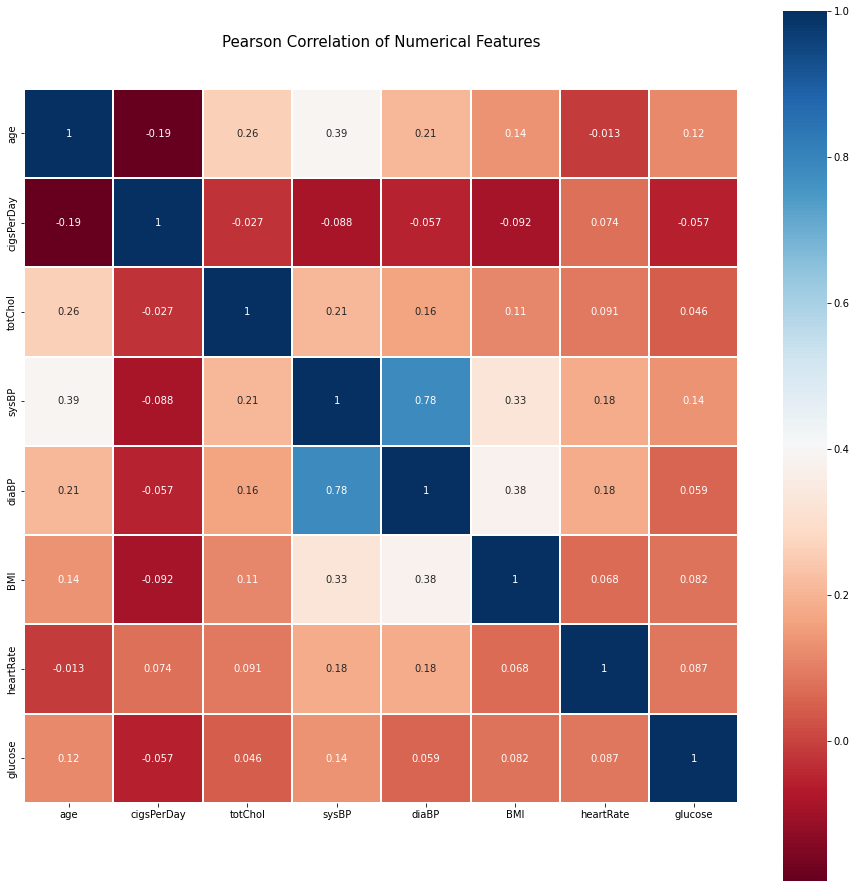

In [28]:
colormap = plt.cm.RdBu
plt.figure(figsize=(16,16))
plt.title('Pearson Correlation of Numerical Features', y=1.05, size=15)
sns.heatmap(df[numerical].corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

There is a high correlation between "diaBP" and "sysBP" features. We might consider to use only one of these two features in our model.

Let's explore numerical features vs. target variable

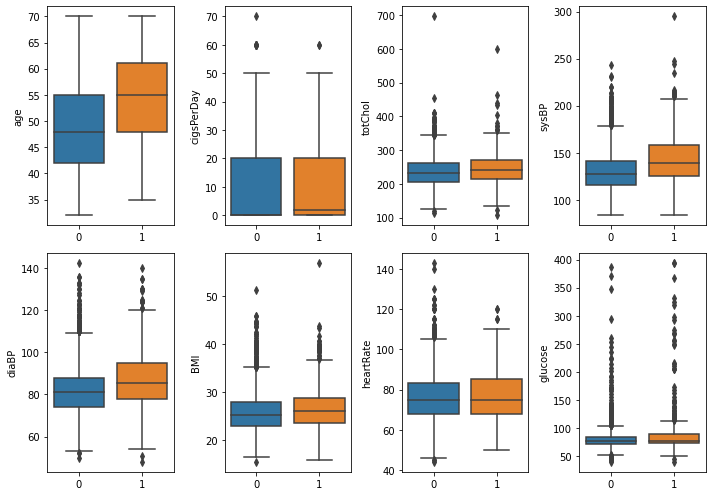

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 7))
for idx, feature in enumerate(numerical):
    ax = axes[int(idx / 4), idx % 4]
    sns.boxplot(x='TenYearCHD', y=feature, data=df, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feature)
fig.tight_layout()

It is noticable that risk of TenYearCHD is higher for the people of higher age as well as people with high higher levels of sysBP and diaBP.

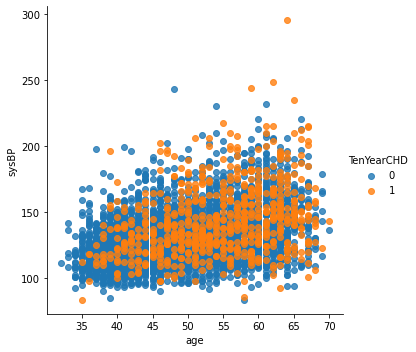

In [43]:
sns.lmplot(
    x="age", y="sysBP", data=df, hue="TenYearCHD", fit_reg=False
)

From the graph above it seems again that there is a trend for people with higher age and higher level of sysBP to have risk of TenYearCHD.

In [64]:
df[numerical].corrwith(df.TenYearCHD)

age           0.225256
cigsPerDay    0.058859
totChol       0.081566
sysBP         0.216429
diaBP         0.145299
BMI           0.074217
heartRate     0.022857
glucose       0.121277
dtype: float64

**What is the mutual info score between categorical features and target variable?**

In [31]:
for cat in categorical:
    print(f'{cat} {mutual_info_score(df.TenYearCHD, df[cat]):.4f}')

male 0.0039
currentSmoker 0.0002
BPMeds 0.0030
prevalentStroke 0.0014
prevalentHyp 0.0148
diabetes 0.0037


It is noticable that "prevalentHyp" feature provides the highest mutual info score for "TenYearCHD" target value. Otherwise, "currentSmoker" feature provides a very little mutual information score for the target value.

In [17]:
df[categorical].nunique()

male               2
currentSmoker      2
BPMeds             2
prevalentStroke    2
prevalentHyp       2
diabetes           2
dtype: int64

<AxesSubplot:xlabel='diabetes', ylabel='count'>

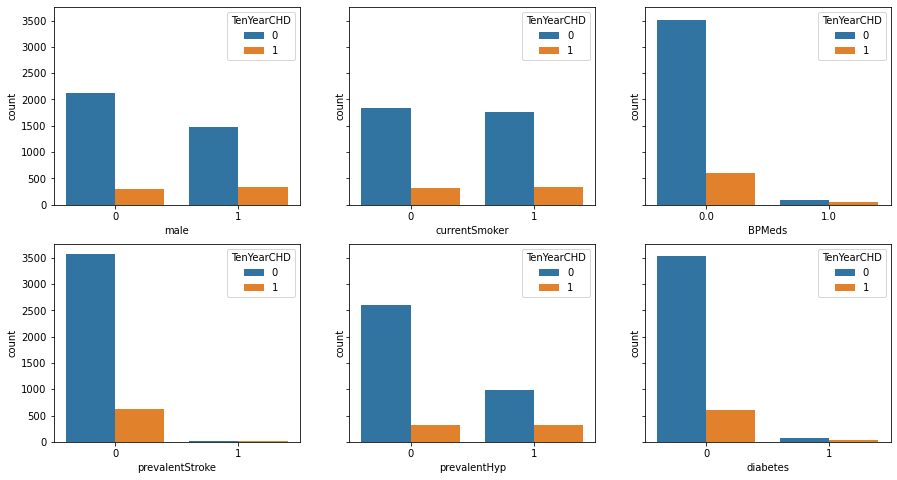

In [48]:
_, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 8))

sns.countplot(x='male', hue='TenYearCHD', data=df, ax=axes[0, 0])
sns.countplot(x='currentSmoker', hue='TenYearCHD', data=df, ax=axes[0, 1])
sns.countplot(x='BPMeds', hue='TenYearCHD', data=df, ax=axes[0, 2])
sns.countplot(x='prevalentStroke', hue='TenYearCHD', data=df, ax=axes[1, 0])
sns.countplot(x='prevalentHyp', hue='TenYearCHD', data=df, ax=axes[1, 1])
sns.countplot(x='diabetes', hue='TenYearCHD', data=df, ax=axes[1, 2])

In [57]:
pd.crosstab(df['TenYearCHD'], df['prevalentStroke'], normalize=True)

prevalentStroke,0,1
TenYearCHD,,
0,0.844738,0.003303
1,0.149363,0.002596


In [55]:
pd.crosstab(df['TenYearCHD'], df['diabetes'], normalize=True)

diabetes,0,1
TenYearCHD,,
0,0.83176,0.016281
1,0.14252,0.009438


In [59]:
pd.crosstab(df['TenYearCHD'], df['currentSmoker'])

currentSmoker,0,1
TenYearCHD,,
0,1833,1761
1,311,333


We can see that dataset is highly unbalanced. One interesting observation is that contingency table for "currentSmoker" feature contains almost the same numbers which means that this feature is not telling us a lot about risk of having TenYearCHD. This proves our conclusion from above based on mutual info score value.

Select features based on conducted EDA: remove "diaBP" and "currentSmoker".

In [438]:
selected_f =  [
    'age', 'cigsPerDay', 'totChol', 'sysBP', 
    'BMI', 'heartRate', 'glucose', 'male', 
    'currentSmoker', 'BPMeds', 'prevalentStroke', 
    'prevalentHyp', 'diabetes', 'TenYearCHD'
]

### Build and Assess the model

#### Remove outliers

Split dataset into 60% train / 20% val / 20% test datasets.

In [527]:
df_full_train, df_test = train_test_split(df[selected_f], test_size=0.2, random_state=13, shuffle=True)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=13, shuffle=True)

In [528]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_full = df_full_train.TenYearCHD.values
y_train = df_train.TenYearCHD.values
y_val = df_val.TenYearCHD.values
y_test = df_test.TenYearCHD.values

del df_full_train['TenYearCHD']
del df_train['TenYearCHD']
del df_val['TenYearCHD']
del df_test['TenYearCHD']

Since we have unbalanced dataset I added class_weights dict.

In [544]:
model = LogisticRegression(C=0.1, class_weight={0:1, 1:4}, max_iter=10000, random_state=13) #class_weight={0:1, 1:2}, max_iter=10000, 
model.fit(df_train.values, y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 4}, max_iter=10000,
                   random_state=13)

In [545]:
y_pred = model.predict(df_val.values)
y_pred_proba = model.predict_proba(df_val.values)[:, 1]

In [546]:
accuracy_score(y_val, y_pred_proba >= 0.5)  # threshold 0.5

0.7405660377358491

In [547]:
scores = []
thresholds = np.linspace(0, 1, 21)
for t in thresholds:
    score = accuracy_score(y_val, y_pred_proba >= t)
    print(f'{t:.2f} {score:.3f}')
    scores.append(score)

0.00 0.154
0.05 0.154
0.10 0.163
0.15 0.238
0.20 0.324
0.25 0.412
0.30 0.495
0.35 0.565
0.40 0.634
0.45 0.693
0.50 0.741
0.55 0.790
0.60 0.810
0.65 0.823
0.70 0.840
0.75 0.847
0.80 0.853
0.85 0.851
0.90 0.848
0.95 0.847
1.00 0.846


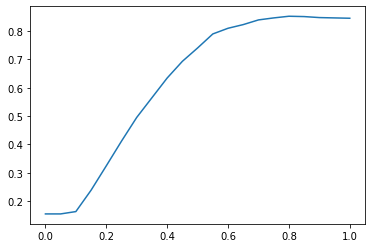

In [548]:
plt.plot(thresholds, scores)

It seems that at threshold 0.65 there is a highest accuracy.

In [549]:
confusion_matrix(y_test, y_pred)

array([[516, 202],
       [ 95,  35]])

Let's calculate the auc score for our model

In [550]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score = round(auc(fpr, tpr), 3)
auc_score

0.732

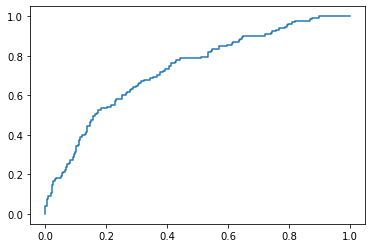

In [551]:
plt.plot(fpr, tpr)

It is interesting to build a dataframe for recall and precision for different thresholds.

In [552]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_proba >= t)
    predict_negative = (y_pred_proba < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

/var/folders/83/dd1dp6cs4n5b8mt9sjqc20kh0000gn/T/ipykernel_2295/1521298580.py:18: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [553]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [554]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,131,717,0,0,0.154481,1.000000
10,0.1,131,710,0,7,0.155767,1.000000
20,0.2,123,565,8,152,0.178779,0.938931
30,0.3,109,406,22,311,0.211650,0.832061
40,0.4,94,273,37,444,0.256131,0.717557
50,0.5,74,163,57,554,0.312236,0.564885
60,0.6,48,78,83,639,0.380952,0.366412
70,0.7,24,29,107,688,0.452830,0.183206
80,0.8,9,3,122,714,0.750000,0.068702
90,0.9,2,0,129,717,1.000000,0.015267


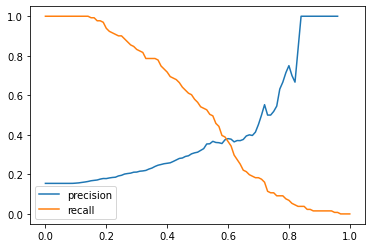

In [555]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

It seems interesting that interception between precision and recall occurs at approx. 0.42 threshold whereas high accuracy could be obtained at 0.65 threshold. Let's calculate and look at f1_score which combines precision and recall metrics.

In [556]:
df_scores['f1_score'] = ((2 * df_scores['precision'] * df_scores['recall']) 
                         / (df_scores['precision'] + df_scores['recall']))

In [557]:
df_scores[df_scores['f1_score'] == df_scores.f1_score.max()]

,threshold,tp,fp,fn,tn,precision,recall,f1_score
53,0.53,69,126,62,591,0.353846,0.526718,0.423313


In [558]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       717
           1       0.31      0.56      0.40       131

    accuracy                           0.74       848
   macro avg       0.61      0.67      0.62       848
weighted avg       0.81      0.74      0.77       848

